## Jordi Blasco Lozano  
### Generación de grafos matcheados – Parte 2

- #### PYTHONPATH para el DataLoader

In [2]:
import os
import sys
sys.path.append(os.path.abspath('..'))



- #### Librerías y Configuración Inicial

    En este bloque se importan las librerías necesarias para la visualización, generación de grafos, generación de triangulaciones y matcheos

    También se importa el módulo **DataLoader** para cargar nuestro dataset de paths.

In [3]:

import numpy as np
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, distance
from scipy.optimize import linear_sum_assignment
import networkx as nx
import pandas as pd
import random
import logging
import matplotlib.colors as mcolors
from node2vec import Node2Vec


from data.dataloader import DataLoader


- #### Configuración del logger
    En esta practica usaremos también la librería logging para generar la información de depuración, usaremos en livel de log de info para que en el momento de ejecución del programa sepamos que está haciendo nuestro programa en todo momento.

In [4]:

# Configurar logging
logging.getLogger("gensim").setLevel(logging.WARNING)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] %(levelname)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.info(f'Logging level: {logging.getLevelName(logger.getEffectiveLevel())}')


[2025-02-28 11:10:32] INFO: Logging level: INFO


- #### Carga del Dataset

In [5]:
# Instanciar el DataLoader y cargar los dataframes
dl = DataLoader()
dlf = dl.load_data()
resultados = "./results/"

- #### Carga de imagenes y plotteo de par de Imagenes 
    En `load_and_preprocess_images()` redimensionaremos las imágenes, indicando en que fila del dataset correspondiente buscar, de esta forma encontraremos las imagenes y puntos correspondientes y las devolveremos todo redimensionado

    Usaremos otra función para cargar los keypoints `load_keypoints_from_row()` y hacer más ligera la ejecución final ya que solo necesitaremos estos puntos. Sería poco practico cargarlo todo si no lo vamos a usar.

    Usaremos `visualize_combined()` para plotear cada par de imagenes que obtendrá como parámetros las imágenes, los puntos, las aristas y una matriz de maching para comprobar si los keypoints de las dos imagenes coinciden y así mostrar la linea roja o verde

In [6]:

def load_and_preprocess_images(row1, row2, target_size=(512,512)):
    """
    Carga y redimensiona dos imágenes junto a sus keypoints a partir de las filas de paths escogidas anteriormente.
    """

    img_path1 = row1['img']
    img_path2 = row2['img']
    mat_path1 = row1['mat']
    mat_path2 = row2['mat']


    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)
    mat_data1 = sio.loadmat(mat_path1)
    mat_data2 = sio.loadmat(mat_path2)
    kpts1 = np.array(mat_data1['pts_coord'])
    kpts2 = np.array(mat_data2['pts_coord'])
    
    # Ajustar los keypoints al nuevo tamaño
    orig_size1 = img1.size
    orig_size2 = img2.size
    kpts1[0] = kpts1[0] * target_size[0] / orig_size1[0]
    kpts1[1] = kpts1[1] * target_size[1] / orig_size1[1]
    kpts2[0] = kpts2[0] * target_size[0] / orig_size2[0]
    kpts2[1] = kpts2[1] * target_size[1] / orig_size2[1]
    
    img1 = img1.resize(target_size, resample=Image.BILINEAR)
    img2 = img2.resize(target_size, resample=Image.BILINEAR)
    
    return img1, img2, kpts1, kpts2


def load_keypoints_from_row(row1, row2):

    mat_path1 = row1['mat']
    mat_path2 = row2['mat']

    kpts1 = np.array(sio.loadmat(mat_path1)['pts_coord'])   
    kpts2 = np.array(sio.loadmat(mat_path2)['pts_coord'])

    return kpts1 , kpts2

def visualize_combined(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching):
    """
    Visualiza de forma combinada dos imágenes, mostrando sus keypoints, grafos de Delaunay y correspondencias (matching).

    La función crea una imagen compuesta colocando las dos imágenes lado a lado. Sobre dicha imagen se dibujan:
      - El grafo de Delaunay para cada imagen, utilizando la matriz de adyacencia (adj_matrix1 y adj_matrix2).
      - Los keypoints detectados sobre cada imagen.
      - Las líneas de matching entre los keypoints de ambas imágenes, donde las correspondencias correctas
        (cuando el índice del keypoint coincide en ambas imágenes) se muestran en verde y las incorrectas en rojo.

    Parámetros:
      img1, img2 Imágenes a visualizar, en formato numpy.ndarray(RGB).
      kpts1, kpts2: Keypoints de las imágenes, en formato numpy.ndarray de tamaño (2, N). ejemplo: [[x1, x2, ..., xN], [y1, y2, , yN]]
      adj_matrix1, adj_matrix2: Matrices de adyacencia de los grafos de Delaunay. ejemplo: [[0, 1, 0], [1, 0, 1], [0, 1, 0]], (las aristas que conectan los keypoints)
      matching: Matriz binaria de tamaño (N, N) que indica las correspondencias entre los keypoints de ambas imágenes. 1 si hay correspondencia, 0 si no. ejemplo: [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    """

    
    # obtenemos las dimensiones (altura y ancho) de ambas imágenes
    h1, w1 = np.array(img1).shape[:2]  
    h2, w2 = np.array(img2).shape[:2]  

    # creamos una imagen compuesta donde se ubicarán ambas imágenes una al lado de la otra.
    # donde la altura de la imagen compuesta será mayor de las dos, y el ancho la suma de ambos anchos.
    composite_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    composite_img[:h1, :w1, :] = img1  # colocamos la primera imagen en la parte izquierda
    composite_img[:h2, w1:w1+w2, :] = img2  # colocamos la segunda imagen en la parte derecha

    # desplazamos los keypoints de la segunda imagen para que se sitúen en la imagen compuesta.
    # y realizamos una copia para no modificar el original y se suma el ancho de la primera imagen a las coordenadas x.
    kpts2_shifted = kpts2.copy()
    kpts2_shifted[0, :] += w1


    plt.figure(figsize=(10, 10))
    plt.imshow(composite_img)


    color = mcolors.CSS4_COLORS['yellow']

    # Primero dibujamos los grafos de Delaunay para ambas imágenes:
    # Se hace uso de las matrices de adyacencia (adj_matrix1 y adj_matrix2) para saber qué keypoints se conectan.
    # Se itera de forma simultánea sobre los keypoints originales (para img1) y los keypoints desplazados (para img2).
    for kpts, adj_matrix in zip([kpts1, kpts2_shifted], [adj_matrix1, adj_matrix2]):
        N = kpts.shape[1]  # Número de keypoints en la imagen actual
        # iteramos sobre cada par de keypoints sin repetir conexiones
        for i in range(N):
            for j in range(i+1, N):
                if adj_matrix[i, j]:
                    # dibujamos una línea entre los keypoints conectados
                    plt.plot([kpts[0, i], kpts[0, j]], [kpts[1, i], kpts[1, j]], '-', color=color, linewidth=1)
        # por ultimo dibujamos los keypoints como puntos sobre la imagen
        plt.scatter(kpts[0], kpts[1], c=color, edgecolors='w', s=80)

    # Segundo dibujamos el matching entre keypoints de ambas imágenes
    # Se localizan los índices de los keypoints que han sido emparejados según la matriz 'matching'
    row_ind, col_ind = np.where(matching == 1)
    for r, c in zip(row_ind, col_ind):
        # Extraemos las coordenadas (x, y) de los keypoints en la primera imagen y en la segunda imagen desplazada
        x1, y1 = kpts1[:, r]
        x2, y2 = kpts2_shifted[:, c]
        # Si el índice coincide, se dibuja la línea de color lima, si no se dibuja en rojo
        if r == c:
            plt.plot([x1, x2], [y1, y2], '-', color=mcolors.CSS4_COLORS['lime'], linewidth=1)
        else:
            # De lo contrario, la línea se dibuja en rojo para indicar un error en la correspondencia
            plt.plot([x1, x2], [y1, y2], '-', color='r' , linewidth=1)


    plt.title("Matching y Triangulación Delaunay")
    plt.axis("off")
    plt.show()



- #### Funcion Delaunay
    Como he explicado en la practica anterior la manera mas sencilla de conectar puntos de un grafo formando triangulos uniformes es usando la `Triangulacion de Delaunay` esto se consigue hacer de la siguiente manera:

    Primero probamos todas las combinaciones posibles juntando 3 puntos formando triangulos, a todos estos triangulos les dibujamos un circulo que pase por los tres vertices, si hay algun punto dentro de este circulo el triangulo se descarta, pero, si no hay ningun círculo extraemos las aristas para formar el grafo final.



In [7]:

def delaunay_triangulation(kpts):
    """
    Construye un grafo usando Delaunay triangulation.
    
    Parámetros:
        - kpts: np.array de shape (2, N) con las coordenadas de los keypoints.
        ejemplo: kpts = np.array([[x1, x2, ..., xN], [y1, y2, ..., yN]])
    
    Devuelve:
        - edges: Lista de tuplas (i, j) representando las aristas del grafo. ejem: [(0, 1), (1, 2), ...]
    """
    pts = kpts.T
    tri = Delaunay(pts)
    N = pts.shape[0]
    A = np.zeros((N, N))
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                A[simplex[i], simplex[j]] = 1
                A[simplex[j], simplex[i]] = 1
    return A


- #### Generación de Embeddings
  Utilizaremos `node2vec` para extraer embeddings de nuestro grafo. Con este método, convertimos la estructura compleja del grafo en una representación de menor dimensión que preserva la proximidad y similitud entre nodos. Esto permitirá realizar análisis posteriores, como el matching espacial, de manera más eficiente.

  El modelo utiliza una variante del algoritmo skip-gram para aprender representaciones donde nodos con contextos similares se ubican cerca en el espacio vectorial.

In [8]:


def compute_node2vec_embeddings(G, dimensions=64, num_walks=10, walk_length=30):
    """
    Calcula embeddings usando node2vec sobre el grafo G.

    Parámetros:
      G: grafo de networkx.
      dimensions: dimensiones de los embeddings.
      num_walks: número de caminatas de cada nodo.
      walk_length: longitud de cada caminata.

    Retorna:
      embeddings: array numpy de tamaño (n, dimensions) con los embeddings de cada nodo.
    """
    # Crear el objeto node2vec; se utiliza un único worker y se deshabilita el logging de progreso.
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=16, quiet=True)
    
    # Entrenar el modelo usando skip-gram.
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
    # Extraer los embeddings. Se asume que los nodos del grafo son identificados por números.
    n = G.number_of_nodes()
    embeddings = np.zeros((n, dimensions))
    for node in G.nodes():
        # node2vec convierte los nodos a string internamente.
        embeddings[node] = model.wv[str(node)]
    return embeddings


- #### Cálculo de Hitting Times
  Utilizaremos dos funciones para estimar y analizar el hitting time en un grafo:

  **1. `hitting_time()`**  
  Esta función aproxima el hitting time (cantidad de pasos necesarios para alcanzar un nodo destino) mediante caminatas aleatorias:
  - Se inicia en el `start_node`.
  - Se realizan caminatas aleatorias (hasta un máximo de 1000 pasos por simulación) eligiendo aleatoriamente un vecino en cada paso.
  - Si se alcanza el `destination_node` o se agota el límite de pasos, se registra el número de pasos ejecutados.
  - Se repite el proceso `num_walks` veces y se devuelve el promedio de pasos.

  **2. `compute_hitting_time_matrix()`**  
  Esta función construye una matriz de hit times para todos los pares de nodos del grafo:
  - Inicializa una matriz (n x n) donde n es el número de nodos.
  - Calcula el hitting time solo para pares (i, j) con i < j, aprovechando la simetría del problema.
  - Rellena tanto la entrada (i, j) como la (j, i) con el valor obtenido.

  Estas funciones permiten evaluar la conectividad y la eficiencia de la navegación entre nodos en el grafo, lo cual es útil para análisis posteriores y para entender la estructura del mismo.

In [9]:

def hitting_time(G, start_node, destination_node, num_walks=100):
    """
    Aproxima el hitting time entre dos nodos mediante caminatas aleatorias.
    """
    hits = []
    for _ in range(num_walks):
        current = start_node
        steps = 0
        while current != destination_node and steps < 1000:
            neighbors = list(G.neighbors(current))
            if not neighbors:
                break
            current = random.choice(neighbors)
            steps += 1
        hits.append(steps)
    return np.mean(hits)

def compute_hitting_time_matrix(G):
    """
    Computa la matriz de hitting times para todos los pares de nodos.
    """
    n = G.number_of_nodes()
    hitting_times = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            h_time = hitting_time(G, i, j)
            hitting_times[i, j] = h_time
            hitting_times[j, i] = h_time
    return hitting_times


- #### Matching Espacial Mejorado

  `enhanced_spatial_matching()` implementa el algoritmo de matching espacial que utiliza múltiples fuentes de información para emparejar keypoints entre dos grafos. El objetivo de esta función es obtener una correspondencia (matching) entre puntos de dos conjuntos (kpts1 y kpts2) combinando:

  - **Distancia espacial:** La distancia euclidiana entre las coordenadas de los puntos.  
  - **Embeddings de node2vec:** Representaciones que capturan la estructura del grafo asociado a cada conjunto de puntos.  
  - **Hitting times:** Medida basada en caminatas aleatorias para estimar la conectividad de cada nodo dentro de su grafo.

  **Pasos del algoritmo:**

  1. **Construcción de Grafos:**  
     Se generan los grafos G1 y G2 a partir de sus respectivas matrices de adyacencia (adj_matrix1 y adj_matrix2). Estas matrices serán la representación de los grafos de keypoints triangulados por Delunay.

  2. **Obtención de Embeddings:**  
     Se calculan los embeddings para cada grafo usando node2vec, generando representaciones vectoriales (node2vec_emb1 y node2vec_emb2) de baja dimensión para cada nodo.

  3. **Cálculo de Hitting Times:**  
     Se computa la matriz de hitting times para cada grafo (hitting_times1 y hitting_times2). Para cada nodo se obtiene un "perfil de hitting time" que se resume mediante el valor medio de sus tiempos de hitting.

  4. **Construcción de la Matriz de Coste:**  
     Se crea una matriz de coste donde cada elemento representa la disimilitud entre un punto del primer conjunto y uno del segundo. Para cada par (i, j) se combinan:
     - **Distancia espacial:** Cálculo de la norma euclidiana entre `kpts1[:, i]` y `kpts2[:, j]`.
     - **Distancia entre embeddings:** Norma euclidiana entre las representaciones obtenidas de node2vec.
     - **Diferencia en hitting times:** Valor absoluto de la diferencia entre los promedios de hitting times de cada nodo.
     
     Estos tres valores se combinan en una única medida de coste ponderada:
     - 40% de la distancia espacial.
     - 30% de la distancia entre embeddings.
     - 30% de la diferencia en hitting profiles.

     Esta matriz cumplirá la siguiente estructura:

     - Si tenemos 2 keypoints en cada conjunto (n1 = n2 = 2), la matriz de costes tendrá la siguiente forma:

       `[[cost₀₀, cost₀₁],`  
       `[cost₁₀, cost₁₁]]`

     - Supongamos los siguientes valores:

       - Para el par (0, 0):
         - Distancia espacial = 2.0  
         - Distancia entre embeddings = 1.5  
         - Diferencia en hitting profiles = 0.5  

         Entonces,  
         cost₀₀ = 0.4×2.0 + 0.3×1.5 + 0.3×0.5 = 0.8 + 0.45 + 0.15 = **1.4**

       - Para el par (0, 1):
         - Distancia espacial = 3.0  
         - Distancia entre embeddings = 2.0  
         - Diferencia en hitting profiles = 0.7  

         Entonces,  
         cost₀₁ = 0.4×3.0 + 0.3×2.0 + 0.3×0.7 ≈ 1.2 + 0.6 + 0.21 = **2.01**

       - Para el par (1, 0):
         - Distancia espacial = 2.5  
         - Distancia entre embeddings = 1.2  
         - Diferencia en hitting profiles = 0.6  

         Entonces,  
         cost₁₀ = 0.4×2.5 + 0.3×1.2 + 0.3×0.6 = 1.0 + 0.36 + 0.18 = **1.54**

       - Para el par (1, 1):
         - Distancia espacial = 1.8  
         - Distancia entre embeddings = 1.0  
         - Diferencia en hitting profiles = 0.4  

         Entonces,  
         cost₁₁ = 0.4×1.8 + 0.3×1.0 + 0.3×0.4 = 0.72 + 0.3 + 0.12 = **1.14**

       La matriz de coste resultante sería:

       ```
       [[1.40, 2.01],
        [1.54, 1.14]]
       ```

       Cada valor en la matriz representa el "desacuerdo" o coste de emparejar los puntos correspondientes, y cuanto menor sea ese valor, mejor se considera la correspondencia. Posteriormente, el algoritmo húngaro utilizará esta matriz para encontrar el matching óptimo.

  5. **Matching Óptimo:**  
     Con la matriz de coste completa, se aplica el algoritmo húngaro (`linear_sum_assignment`) para encontrar el emparejamiento óptimo entre los dos conjuntos, minimizando el coste total de correspondencia.

     **Ejemplo con la matriz 2x2 anterior:**

     - La matriz de coste es:

       ```
       [[1.40, 2.01],
        [1.54, 1.14]]
       ```

     - Se evalúan las asignaciones posibles:
       - Opción A: Emparejar el keypoint 0 del primer conjunto con el keypoint 0 del segundo, y el keypoint 1 con el keypoint 1.
         - Coste total = 1.40 + 1.14 = **2.54**
       - Opción B: Emparejar el keypoint 0 del primer conjunto con el keypoint 1 del segundo, y el keypoint 1 con el keypoint 0.
         - Coste total = 2.01 + 1.54 = **3.55**

     - El algoritmo húngaro selecciona la opción que minimiza el coste global, en este caso la Opción A, es decir:
       ```
       [(0, 0), (1, 1)]
       ```
       

  Este matching espacial mejorado sirve para emparejar puntos clave de manera robusta, aprovechando no solo la proximidad geométrica, sino también la información estructural proporcionada por los grafos y la conectividad interna (hitting times). Esto es especialmente útil en tareas de visión por computadora, registro de imágenes y análisis de estructuras complejas.

In [10]:
def compute_cost_components(kpts1, kpts2, adj_matrix1, adj_matrix2):
    """
    Realiza el emparejamiento de puntos clave entre dos conjuntos combinando información espacial, embeddings obtenidos mediante node2vec y hitting times de grafos.

    Parámetros:
      - kpts1, kpts2: Arrays de puntos clave de los dos conjuntos, de forma (dimensiones, n1) y (dimensiones, n2) respectivamente. ejemplo: [[x1, x2, ..., xN], [y1, y2, ..., yN]]

      - adj_matrix1, adj_matrix2: Matrices de adyacencia de los grafos de Delaunay para los dos conjuntos de puntos clave. ejemplo: [[0, 1, 0], [1, 0, 1], [0, 1, 0]]

    Retorna:
      np.ndarray: Matriz binaria de matching de forma (n1, n2) que indica las correspondencias óptimas. 
    """
    # Paso 1: Determinar el número de puntos clave en cada conjunto y crear los grafos
    n1 = kpts1.shape[1]
    n2 = kpts2.shape[1]

    G1 = nx.from_numpy_array(adj_matrix1)
    G2 = nx.from_numpy_array(adj_matrix2)
    
    # Paso 2: Calcular los embeddings de node2vec para cada grafo
    node2vec_emb1 = compute_node2vec_embeddings(G1)
    node2vec_emb2 = compute_node2vec_embeddings(G2)
    
    # Paso 3: Calcular las matrices de hitting times para cada grafo
    hitting_times1 = compute_hitting_time_matrix(G1)  # Matriz de tamaño (n1, n1)
    hitting_times2 = compute_hitting_time_matrix(G2)  # Matriz de tamaño (n2, n2)


    cost_spatial = np.zeros((n1, n2))
    cost_node2vec = np.zeros((n1, n2))
    cost_hitting = np.zeros((n1, n2))
    
    # Recorrer cada punto de cada conjunto 1 a 1
    for i in range(n1):
        # Calcular el valor medio del hitting time para el nodo i en el primer grafo
        profile1 = np.mean(hitting_times1[i])
        for j in range(n2):
            # Calcular el valor medio del hitting time para el nodo j en el segundo grafo
            profile2 = np.mean(hitting_times2[j])
            
            cost_spatial[i, j] = np.linalg.norm(kpts1[:, i] - kpts2[:, j])
            cost_node2vec[i, j] = np.linalg.norm(node2vec_emb1[i] - node2vec_emb2[j])
            cost_hitting[i, j] = abs(profile1 - profile2)

    return cost_spatial, cost_node2vec, cost_hitting


def compute_matching(cost_spatial, cost_node2vec, cost_hitting, w_spatial=0.4, w_node2vec=0.3, w_hitting=0.3):
    """
    Combina las matrices de costo con los pesos indicados y calcula el matching óptimo.
    Retorna:
      - matching: Matriz binaria de matching (n1 x n2)
      - cost_matrix: Matriz de costo combinada.
    """
    # Combinar las matrices de costo según los pesos
    cost_matrix = (w_spatial * cost_spatial +
                   w_node2vec * cost_node2vec +
                   w_hitting * cost_hitting)
    
    # Aplicar el algoritmo húngaro
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    matching = np.zeros_like(cost_matrix, dtype=int)
    matching[row_ind, col_ind] = 1
    
    return matching




- #### Evaluación del Matching Avanzado

    Finalmente, toda la teoria anterior la ponemos en practica usando estas dos funciones:  
- `evaluate_matching_precision()`, calcula la precisión del matching asumiendo la diagonal como correspondencia ideal.  
- `compute_precision_for_all_categories()`, la función `main` que selecciona aleatoriamente un par de imágenes para visualización con matching combinado. Después, recorre todos los pares posibles de grafos en cada categoría (1 grafo con todos los demas, despues el siguiente y así sin repetir), calcula las triangulaciones de Delaunay y se aplica `enhanced_spatial_matching()`. Los resultados se evalúan mediante la precisión del matching, calculando la media y desviación estándar para cada categoría. Finalmente, se recopilan todos los resultados en un `pandas.df` que se exporta como archivo `results2.csv`.

In [11]:
def evaluate_matching_precision(kpts, matching):
    """
    Calcula la precisión del matching de keypoints asumiendo que la correspondencia ideal es la diagonal de la matriz.

    Parámetros:
    -----------
    kpts : np.ndarray de tamaño (2, N)
        Array de keypoints, donde la primera fila contiene las coordenadas x y la segunda las coordenadas y.
    matching : np.ndarray de tamaño (N, N)
        Matriz binaria que indica las correspondencias entre los keypoints de dos imágenes.
        Un valor de 1 en matching[i, j] significa que el keypoint i de la primera imagen se empareja con el keypoint j de la segunda imagen.

    Proceso:
    --------
    1. Se obtiene N, el número de keypoints.
    2. Se extraen los índices (fila, columna) de los elementos donde matching es 1.
    3. Se considera correcto un emparejamiento si el índice de la fila es igual al de la columna (se asume que la correspondencia ideal es la diagonal de la matriz).
    4. Se calcula la precisión como el número de emparejamientos correctos dividido entre N.
       - Si N es 0, se retorna 0 para evitar división por cero.

    Retorna:
    --------
    float:
        Precisión del matching, en el rango [0, 1].
    """
    N = kpts.shape[1]
    # Obtener las posiciones donde matching tiene un 1
    row_ind, col_ind = np.where(matching == 1)
    # Contar cuántos emparejamientos están en la diagonal (i.e., índices iguales)
    correct = np.sum(row_ind == col_ind)
    # Retornar la precisión, evitando división por cero
    return correct / N if N != 0 else 0



In [12]:


def visualizacion_final(dlf):
    """
    Evalúa la precisión del matching avanzado de keypoints para cada categoría y guarda los resultados en un archivo CSV.

    Parámetros:
    -----------
    dlf: pandas.df de paths con las imágenes y keypoints de cada categoría.

    Proceso:
    --------
    - Para cada categoría:
       1. Se selecciona aleatoriamente un par de imágenes y se muestra la visualización utilizando el matching avanzado (enhanced_spatial_matching).
       2. Se recorren todos los pares (sin repetir combinaciones) de la categoría:
          - Se cargan los keypoints correspondientes a cada par de imágenes.
          - Se calcula la triangulación de Delaunay para obtener la matriz de adyacencia.
          - Se realiza el matching avanzado usando enhanced_spatial_matching.
          - Se evalúa la precisión del matching con evaluate_matching_precision.
       3. Se calcula la precisión media y la desviación estándar del matching en la categoría.
       4. Se registran los resultados en un diccionario.

    - Se guardan los resultados de todas las categorías en un DataFrame y se exportan a "results2.csv".

    Retorna:
    --------
    pandas.df: con las métricas de precisión para cada categoría analizada.

    """
    overall_results = []  # Acumula resultados globales para cada categoría

    # Iterar sobre cada categoría en el dataset
    for cat_name, cat_df in dlf.items():

        if cat_name == '__pycache___df':
            continue  # Omitir entradas no relevantes

        # Paso 1: Visualizar un par aleatorio de imágenes con matching avanzado
        sample = cat_df.sample(2)  # Seleccionar dos imágenes al azar
        row1 = sample.iloc[0]
        row2 = sample.iloc[1]

        # Cargar imágenes y keypoints preprocesados
        img1, img2, kpts1, kpts2 = load_and_preprocess_images(row1, row2)

        # Calcular la triangulación de Delaunay para construir la matriz de adyacencia de keypoints
        adj1 = delaunay_triangulation(kpts1)
        adj2 = delaunay_triangulation(kpts2)

        # Realizar el matching avanzado
        cost_spatial, cost_node2vec, cost_hitting = compute_cost_components(kpts1, kpts2, adj1, adj2)
        matching = compute_matching(cost_spatial, cost_node2vec, cost_hitting, 
                                       w_spatial=0.4, w_node2vec=0.3, w_hitting=0.3)
        logger.info(f"Visualizando par aleatorio para {cat_name}")

        # Visualizar la combinación de imágenes, keypoints, triangulación y matching
        visualize_combined(img1, img2, kpts1, kpts2, adj1, adj2, matching)


[2025-02-28 11:10:50] INFO: Visualizando par aleatorio para car_df


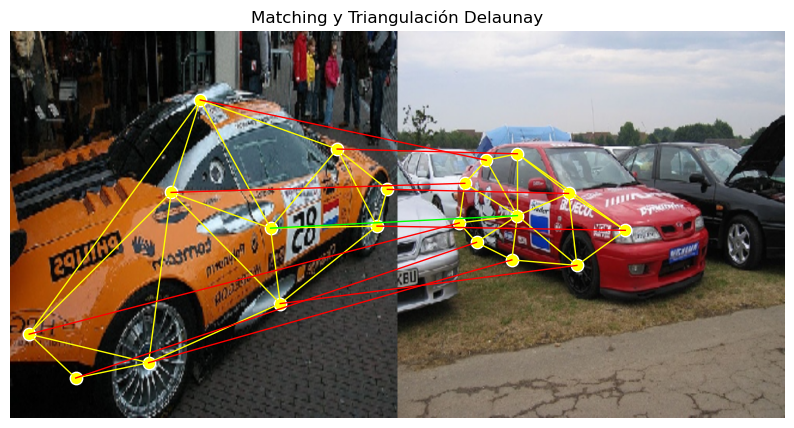

[2025-02-28 11:10:51] INFO: Visualizando par aleatorio para duck_df


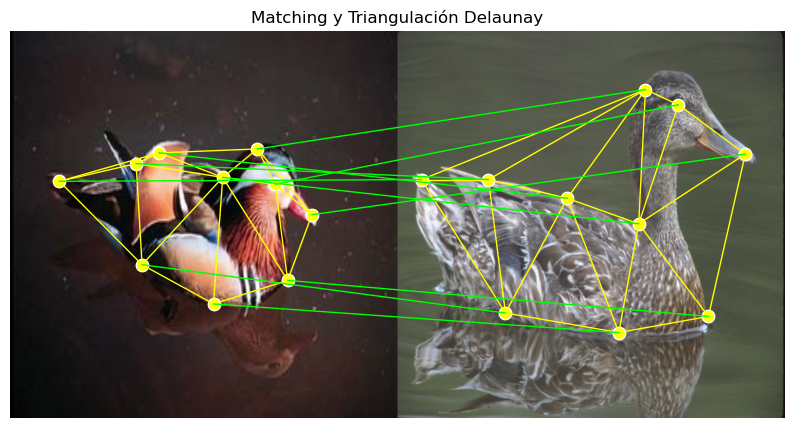

[2025-02-28 11:10:51] INFO: Visualizando par aleatorio para face_df


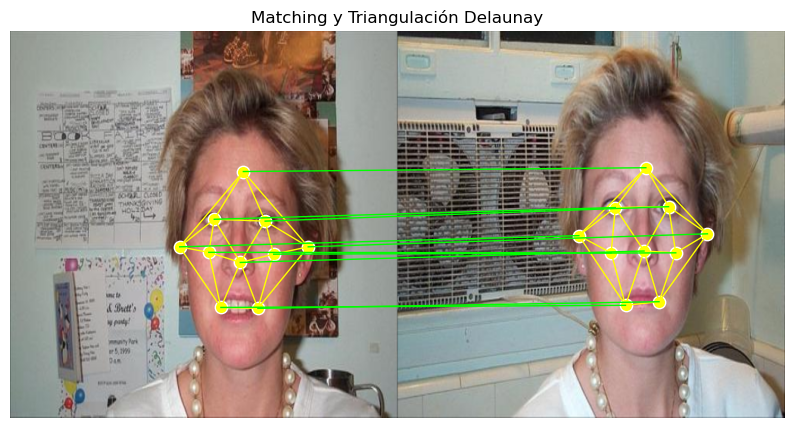

[2025-02-28 11:10:51] INFO: Visualizando par aleatorio para motorbike_df


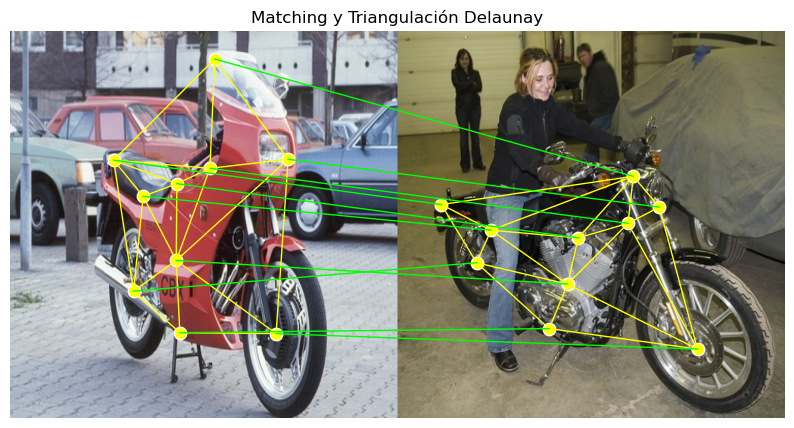

[2025-02-28 11:10:52] INFO: Visualizando par aleatorio para winebottle_df


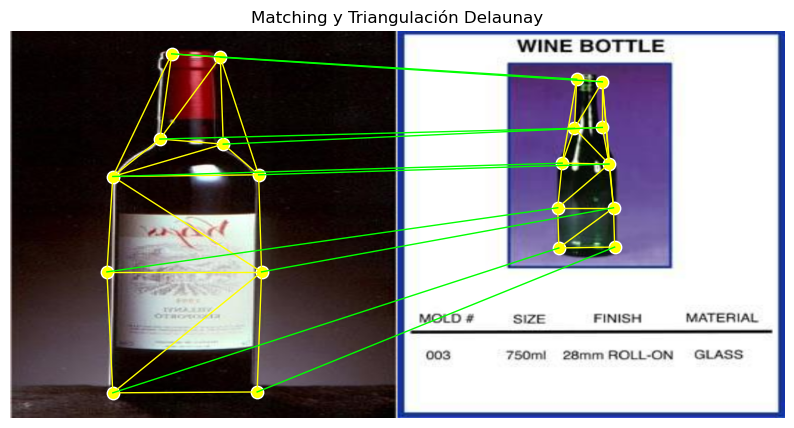

In [13]:
visualizacion_final(dlf)

In [35]:
def compute_precision_for_all_categories(dlf):
    """

    """
    overall_results = []  # Acumula resultados globales para cada categoría

    # Iterar sobre cada categoría en el dataset
    for cat_name, cat_df in dlf.items():

        if cat_name == '__pycache___df':
            continue  # Omitir entradas no relevantes

        # Paso 2: Calcular la precisión del matching para todos los pares de imágenes en la categoría
        precisions = []
        n = len(cat_df)
        num_pairs = 0
        
        for i in range(n - 1):
            for j in range(i + 1, n):

                row_a = cat_df.iloc[i]
                row_b = cat_df.iloc[j]

                
                kpts1, kpts2 = load_keypoints_from_row(row_a, row_b)

                # Calcular la triangulación de Delaunay para cada conjunto de keypoints
                adj1 = delaunay_triangulation(kpts1)
                adj2 = delaunay_triangulation(kpts2)

                # Realizar el matching avanzado para el par
                cost_spatial, cost_node2vec, cost_hitting = compute_cost_components(kpts1, kpts2, adj1, adj2)
                matching = compute_matching(cost_spatial, cost_node2vec, cost_hitting)


                # Evaluar la precisión del matching
                prec = evaluate_matching_precision(kpts1, matching)
                precisions.append(prec)

        # Paso 3: Calcular la precisión media y la desviación estándar
        mean_prec = np.mean(precisions)
        std_prec = np.std(precisions)
        
        # Registrar en el log la precisión media, la desviación y el número de imágenes procesadas
        logger.info(f"Baseline Analysis - Category {cat_name.capitalize()}: Mean Accuracy = {mean_prec:.4f}, Std Deviation = {std_prec:.4f}, Pairs Evaluated = {num_pairs}")
        
        # Paso 4: Registrar los resultados en el diccionario de resultados globales
        overall_results.append({
            "Category": cat_name,
            "Mean_Accuracy": round(mean_prec, 4),
            "Std_Deviation": round(std_prec, 4),
            "Number_of_Pairs": num_pairs
        })

    # Paso final: guardamos los resultados globales en un pandas.df y exportamos a CSV
    results_df = pd.DataFrame(overall_results)
    results_df.to_csv(f"{resultados}(0.4,0.3,0.3).csv", index=False)
    logger.info(f"Resultados globales guardados en {resultados}(0.4,0.3,0.3).csv")

    return results_df

In [36]:
matching_433_results = compute_precision_for_all_categories(dlf)
matching_433_results

[2025-02-28 11:31:40] INFO: Baseline Analysis - Category Car_df: Mean Accuracy = 0.7863, Std Deviation = 0.2709, Pairs Evaluated = 0
[2025-02-28 11:37:02] INFO: Baseline Analysis - Category Duck_df: Mean Accuracy = 0.7061, Std Deviation = 0.2798, Pairs Evaluated = 0
[2025-02-28 12:05:07] INFO: Baseline Analysis - Category Face_df: Mean Accuracy = 0.9073, Std Deviation = 0.1511, Pairs Evaluated = 0
[2025-02-28 12:08:46] INFO: Baseline Analysis - Category Motorbike_df: Mean Accuracy = 0.8690, Std Deviation = 0.2067, Pairs Evaluated = 0
[2025-02-28 12:19:34] INFO: Baseline Analysis - Category Winebottle_df: Mean Accuracy = 0.8912, Std Deviation = 0.1710, Pairs Evaluated = 0
[2025-02-28 12:19:34] INFO: Resultados globales guardados en ./results/(0.4,0.3,0.3).csv


,Category,Mean_Accuracy,Std_Deviation,Number_of_Pairs
0,car_df,0.7863,0.2709,0
1,duck_df,0.7061,0.2798,0
2,face_df,0.9073,0.1511,0
3,motorbike_df,0.8690,0.2067,0
4,winebottle_df,0.8912,0.1710,0


In [ ]:
def baseline_analisis(dlf):
    """
    Realiza un análisis baseline usando matching únicamente espacial con Delaunay.
    
    Para cada categoría en el dataset (dlf) se:
      1. Iteran todos los pares de imágenes.
      2. Se extraen los keypoints de cada imagen usando load_keypoints_from_row.
      3. Se calcula la matriz de coste usando solamente la distancia euclidiana entre keypoints.
      4. Se aplica el algoritmo húngaro para obtener el matching.
      5. Se evalúa la precisión asumiendo la diagonal como matching ideal.
    
    Los resultados (precisión media y desviación estándar) se registran por categoría y se exportan a "baseline_results.csv".
    """
    overall_results = []  # Acumula los resultados por categoría

    # Iterar sobre cada categoría en el dataset
    for cat_name, cat_df in dlf.items():
        if cat_name == '__pycache___df':
            continue  # Omitir entradas no relevantes

        baseline_precisions = []  # Almacena la precisión de cada par de imágenes
        num_pairs = 0

        # Iterar sobre todas las combinaciones sin repetición de imágenes en la categoría
        for i in range(len(cat_df) - 1):
            for j in range(i + 1, len(cat_df)):
                row_a = cat_df.iloc[i]
                row_b = cat_df.iloc[j]

                # Extraer keypoints usando la función ya definida
                kpts1, kpts2 = load_keypoints_from_row(row_a, row_b)

                n1 = kpts1.shape[1]
                n2 = kpts2.shape[1]

                # Calcular la matriz de coste únicamente con la distancia euclidiana
                cost_matrix = np.zeros((n1, n2))
                for p in range(n1):
                    for q in range(n2):
                        cost_matrix[p, q] = np.linalg.norm(kpts1[:, p] - kpts2[:, q])

                # Aplicar el algoritmo húngaro para obtener el matching óptimo
                row_ind, col_ind = linear_sum_assignment(cost_matrix)
                matching = np.zeros_like(cost_matrix, dtype=int)
                matching[row_ind, col_ind] = 1

                # Evaluar la precisión usando la función definida (asume que la diagonal es la correspondencia ideal)
                prec = evaluate_matching_precision(kpts1, matching)
                baseline_precisions.append(prec)
                num_pairs += 1

        # Si se evaluó al menos un par, calcular la media y la desviación; en caso contrario, se asigna 0

        mean_prec = np.mean(baseline_precisions)
        std_prec = np.std(baseline_precisions)


        logger.info(f"Baseline Analysis - Category {cat_name.capitalize()}: Mean Accuracy = {mean_prec:.4f}, Std Deviation = {std_prec:.4f}, Pairs Evaluated = {num_pairs}")
        overall_results.append({
            "Category": cat_name,
            "Mean_Accuracy": round(mean_prec, 4),
            "Std_Deviation": round(std_prec, 4),
            "Number_of_Pairs": num_pairs
        })

    # Crear un DataFrame con los resultados globales y exportarlo a CSV
    results_df = pd.DataFrame(overall_results)
    results_df.to_csv(f"{resultados}baseline_results.csv", index=False)
    logger.info(f"Baseline analysis results guardados en {resultados}baseline_results.csv")
    return results_df

In [ ]:
baseline_rs = baseline_analisis(dlf)
baseline_rs

[2025-02-27 23:49:24] INFO: Baseline Analysis - Category Car_df: Mean Accuracy = 0.7118, Std Deviation = 0.3007, Pairs Evaluated = 780
[2025-02-27 23:49:25] INFO: Baseline Analysis - Category Duck_df: Mean Accuracy = 0.6753, Std Deviation = 0.2878, Pairs Evaluated = 1225
[2025-02-27 23:49:29] INFO: Baseline Analysis - Category Face_df: Mean Accuracy = 0.8452, Std Deviation = 0.1879, Pairs Evaluated = 5886
[2025-02-27 23:49:30] INFO: Baseline Analysis - Category Motorbike_df: Mean Accuracy = 0.8265, Std Deviation = 0.2302, Pairs Evaluated = 780
[2025-02-27 23:49:32] INFO: Baseline Analysis - Category Winebottle_df: Mean Accuracy = 0.8826, Std Deviation = 0.1792, Pairs Evaluated = 2145
[2025-02-27 23:49:32] INFO: Baseline analysis results saved to baseline_results.csv


In [ ]:
def enhanced_matching_with_delaunay(dlf):
    """
    Realiza un análisis avanzado de matching combinando información espacial y estructural usando triangulación de Delaunay.
    
    Para cada categoría en el dataset (dlf) se:
      1. Iteran todos los pares de imágenes.
      2. Se extraen los keypoints de cada imagen usando load_keypoints_from_row.
      3. Se calcula la triangulación de Delaunay para generar las matrices de adyacencia.
      4. Se obtienen las componentes de coste:
         - Distancia espacial.
         - Distancia entre embeddings generados con node2vec.
         - Diferencia en perfiles de hitting times.
      5. Se combinan estos costes (ponderación: 40% espacial, 30% node2vec, 30% hitting times) y se aplica el algoritmo húngaro para obtener el matching óptimo.
      6. Se evalúa la precisión asumiendo la diagonal como correspondencia ideal.
    
    Los resultados (precisión media y desviación estándar) se registran por categoría y se exportan a "enhanced_results.csv".
    """
    overall_results = []  # Acumula los resultados por categoría

    # Iterar sobre cada categoría en el dataset
    for cat_name, cat_df in dlf.items():
        if cat_name == '__pycache___df':
            continue  # Omitir entradas no relevantes
            
        enhanced_precisions = []  # Almacena la precisión de cada par de imágenes
        num_pairs = 0

        # Iterar sobre todas las combinaciones sin repetición de imágenes en la categoría
        for i in range(len(cat_df) - 1):
            for j in range(i + 1, len(cat_df)):
                row_a = cat_df.iloc[i]
                row_b = cat_df.iloc[j]

                # Extraer keypoints usando la función definida
                kpts1, kpts2 = load_keypoints_from_row(row_a, row_b)

                # Calcular la triangulación de Delaunay para generar las matrices de adyacencia
                adj1 = delaunay_triangulation(kpts1)
                adj2 = delaunay_triangulation(kpts2)

                # Calcular las componentes de coste (espacial, embeddings, hitting times)
                cost_spatial, cost_node2vec, cost_hitting = compute_cost_components(kpts1, kpts2, adj1, adj2)
                # Combinar los costes y obtener el matching óptimo
                matching = compute_matching(cost_spatial, cost_node2vec, cost_hitting, w_spatial=0.4, w_node2vec=0.3, w_hitting=0.3)

                # Evaluar la precisión del matching (ideal: diagonal)
                prec = evaluate_matching_precision(kpts1, matching)
                enhanced_precisions.append(prec)
                num_pairs += 1

        # Si se evaluó al menos un par, calcular la media y desviación; de lo contrario, asignar 0

        mean_prec = np.mean(enhanced_precisions)
        std_prec = np.std(enhanced_precisions)


        logger.info(f"Enhanced Matching - Category {cat_name.capitalize()}: Mean Accuracy = {mean_prec:.4f}, Std Deviation = {std_prec:.4f}, Pairs Evaluated = {num_pairs}")
        overall_results.append({
            "Category": cat_name,
            "Mean_Accuracy": round(mean_prec, 4),
            "Std_Deviation": round(std_prec, 4),
            "Number_of_Pairs": num_pairs
        })

    # Crear un DataFrame con los resultados globales y exportarlo a CSV
    results_df = pd.DataFrame(overall_results)
    results_df.to_csv(f"{resultados}enhanced_results.csv", index=False)
    logger.info(f"Enhanced matching results guardados en {resultados}enhanced_results.csv")
    return results_df

In [ ]:
delunay_spatial_rs = enhanced_matching_with_delaunay(dlf)
delunay_spatial_rs

In [23]:
def knn_matching(kpts1, kpts2, k):
    """
    Realiza un emparejamiento entre keypoints usando el algoritmo de los K-Nearest Neighbors.
    
    Parámetros:
      - kpts1, kpts2: np.array de shape (2, N) con las coordenadas de los keypoints.
      - k: número de vecinos a considerar.
      
    Devuelve:
      - matching: np.array binaria de forma (N, N) donde para cada keypoint de kpts1
        se marca 1 en las posiciones correspondientes a los k vecinos más cercanos de kpts2.
    """
    
    cost_matrix = distance.cdist(kpts1.T, kpts2.T, metric="euclidean")
    N = cost_matrix.shape[0]
    matching = np.zeros(cost_matrix.shape, dtype=int)
    # Para cada keypoint en kpts1, actualizar los k vecinos más cercanos en kpts2
    for i in range(N):
        nearest_indices = np.argsort(cost_matrix[i])[:k]
        matching[i, nearest_indices] = 1
    return matching

def knn_analysis_for_category(dlf, cat_name, k_values=[3,5,7]):
    """
    Realiza un análisis detallado de matching usando KNN para una categoría seleccionada.
    
    Para cada par de imágenes en la categoría:
       - Se calculan los matching usando KNN con distintos valores de k.
    
    Los resultados (precisión media y desviación estándar) se registran para cada método y
    se exportan a "knn_results.csv".
    
    Parámetros:
      - cat_df: DataFrame de una categoría (del DataLoader) con los paths de imágenes y keypoints.
      - k_values: Lista con los valores de k a evaluar (por defecto [3,5,7]).
      
    Retorna:
      - results_df: DataFrame con las métricas para cada método evaluado.
    """
    cat_df = dlf[cat_name]

    overall_results = []
    # Inicializar diccionarios para acumular precisiones:
    prec_results = {f'KNN({k})': [] for k in k_values}
    num_pairs = 0

    # Iterar sobre todas las combinaciones sin repetición de imágenes en la categoría
    for i in range(len(cat_df) - 1):
        for j in range(i + 1, len(cat_df)):
            row_a = cat_df.iloc[i]
            row_b = cat_df.iloc[j]
            # Extraer keypoints (sin preprocesamiento adicional en esta función)
            kpts1, kpts2 = load_keypoints_from_row(row_a, row_b)

            # Matching KNN para cada valor de k
            for k in k_values:
                knn_match = knn_matching(kpts1, kpts2, k)
                prec = evaluate_matching_precision(kpts1, knn_match)
                prec_results[f'KNN({k})'].append(prec)

            num_pairs += 1

    # Calcular las métricas para cada método y registrarlas
    for method, prec_list in prec_results.items():
        if prec_list:
            mean_prec = np.mean(prec_list)
            std_prec = np.std(prec_list)
        else:
            mean_prec, std_prec = 0, 0
        overall_results.append({
            "Method": method,
            "Mean_Accuracy": round(mean_prec, 4),
            "Std_Deviation": round(std_prec, 4),
            "Number_of_Pairs": num_pairs
        })
        logger.info(f"{method} Analysis: Mean Accuracy = {mean_prec:.4f}, Std Deviation = {std_prec:.4f}, Pairs Evaluated = {num_pairs}")

    # Guardar resultados en CSV
    results_df = pd.DataFrame(overall_results)
    results_df.to_csv(f"{resultados}{cat_name}_knn_results.csv", index=False)
    logger.info(f"KNN analysis results guardados en {resultados}{cat_name}_knn_results.csv")
    return results_df

In [24]:
knn_rs = knn_analysis_for_category(dlf, 'duck_df' , k_values=[3, 5, 7])
knn_rs

[2025-02-28 11:14:58] INFO: KNN(3) Analysis: Mean Accuracy = 0.6283, Std Deviation = 0.2149, Pairs Evaluated = 1225
[2025-02-28 11:14:58] INFO: KNN(5) Analysis: Mean Accuracy = 0.8202, Std Deviation = 0.1619, Pairs Evaluated = 1225
[2025-02-28 11:14:58] INFO: KNN(7) Analysis: Mean Accuracy = 0.9223, Std Deviation = 0.1021, Pairs Evaluated = 1225
[2025-02-28 11:14:58] INFO: KNN analysis results guardados en ./results/duck_df_knn_results.csv


,Method,Mean_Accuracy,Std_Deviation,Number_of_Pairs
0,KNN(3),0.6283,0.2149,1225
1,KNN(5),0.8202,0.1619,1225
2,KNN(7),0.9223,0.1021,1225


In [33]:
def weight_sensitivity_analysis_for_category(dlf, cat_name, weight_combinations=[(0.3, 0.3, 0.4),
                                                                                    (0.3, 0.4, 0.3),
                                                                                    (0.4, 0.3, 0.3),
                                                                                    (0.5, 0.2, 0.3),
                                                                                    (0.5, 0.3, 0.2),
                                                                                    (0.6, 0.2, 0.2)]):
    """
    Realiza un análisis de sensibilidad de pesos en el matching avanzado para una categoría seleccionada.
    
    Para cada combinación de pesos (espacial, node2vec, hitting time) se:
      - Iteran todos los pares de imágenes de la categoría.
      - Se extraen los keypoints y se calcula la triangulación de Delaunay para cada imagen.
      - Se obtienen las componentes de coste usando compute_cost_components (calculadas una única vez por par).
      - Se combina la información con los pesos especificados y se obtiene el matching óptimo 
        mediante compute_matching.
      - Se evalúa la precisión del matching usando evaluate_matching_precision.
    
    Los resultados (precisión media, desviación estándar y número de pares evaluados) se registran para cada
    combinación de pesos y se exportan en un CSV para la categoría.
    
    Parámetros:
      - dlf: Diccionario o DataFrame con los paths y keypoints de cada categoría.
      - cat_name: Nombre de la categoría a evaluar.
      - weight_combinations: Lista de tuplas con combinaciones de pesos (w_spatial, w_node2vec, w_hitting)
                             a evaluar.
    
    Retorna:
      - results_df: DataFrame con las métricas para cada combinación de pesos evaluada.
    """
    cat_df = dlf[cat_name]
    overall_results = []
    # Diccionario para acumular las precisiones por cada combinación de pesos a lo largo de todos los pares
    precision_by_weight = {ws: [] for ws in weight_combinations}
    num_pairs = 0
    
    # Iterar sobre todas las combinaciones sin repetición de imágenes en la categoría
    for i in range(len(cat_df) - 1):
        for j in range(i + 1, len(cat_df)):
            row_a = cat_df.iloc[i]
            row_b = cat_df.iloc[j]
            
            # Extraer keypoints para ambos pares
            kpts1, kpts2 = load_keypoints_from_row(row_a, row_b)
            
            # Calcular triangulación de Delaunay para generar las matrices de adyacencia
            adj1 = delaunay_triangulation(kpts1)
            adj2 = delaunay_triangulation(kpts2)
            
            # Obtener las componentes de coste una sola vez para el par
            cost_spatial, cost_node2vec, cost_hitting = compute_cost_components(kpts1, kpts2, adj1, adj2)
            
            # Para cada combinación de pesos, calcular el matching y evaluar la precisión
            for ws in weight_combinations:
                w_spatial, w_node2vec, w_hitting = ws
                matching= compute_matching(cost_spatial, cost_node2vec, cost_hitting,
                                               w_spatial=w_spatial, w_node2vec=w_node2vec, w_hitting=w_hitting)
                prec = evaluate_matching_precision(kpts1, matching)
                precision_by_weight[ws].append(prec)
            
            num_pairs += 1

    # Calcular la precisión media y desviación estándar para cada combinación de pesos
    for ws in weight_combinations:
        precs = precision_by_weight[ws]
        mean_prec = np.mean(precs) if precs else 0
        std_prec = np.std(precs) if precs else 0
        
        overall_results.append({
            "Weight_Combination": f"({ws[0]}, {ws[1]}, {ws[2]})",
            "Mean_Accuracy": round(mean_prec, 4),
            "Std_Deviation": round(std_prec, 4),
            "Number_of_Pairs": num_pairs
        })
        logger.info(f"Weight Combination ({ws[0]}, {ws[1]}, {ws[2]}): Mean Accuracy = {mean_prec:.4f}, Std Deviation = {std_prec:.4f}, Pairs Evaluated = {num_pairs}")
    
    # Crear un DataFrame con los resultados y exportarlo a CSV.
    # Se asume que 'resultados' es una variable global con el path donde guardar los CSV;
    # en caso contrario, se utiliza el nombre de la categoría.
    filename = f"{resultados}{cat_name}_weight_sensitivity_results.csv" if 'resultados' in globals() else f"{cat_name}_weight_sensitivity_results.csv"
    results_df = pd.DataFrame(overall_results)
    results_df.to_csv(filename, index=False)
    logger.info(f"Weight sensitivity analysis results guardados en {filename}")
    
    return results_df


In [34]:
sensitivity_rs = weight_sensitivity_analysis_for_category(dlf,'duck_df')
sensitivity_rs

[2025-02-28 11:27:00] INFO: Weight Combination (0.3, 0.3, 0.4): Mean Accuracy = 0.7106, Std Deviation = 0.2758, Pairs Evaluated = 1225
[2025-02-28 11:27:00] INFO: Weight Combination (0.3, 0.4, 0.3): Mean Accuracy = 0.7088, Std Deviation = 0.2782, Pairs Evaluated = 1225
[2025-02-28 11:27:00] INFO: Weight Combination (0.4, 0.3, 0.3): Mean Accuracy = 0.7074, Std Deviation = 0.2811, Pairs Evaluated = 1225
[2025-02-28 11:27:00] INFO: Weight Combination (0.5, 0.2, 0.3): Mean Accuracy = 0.7049, Std Deviation = 0.2824, Pairs Evaluated = 1225
[2025-02-28 11:27:00] INFO: Weight Combination (0.5, 0.3, 0.2): Mean Accuracy = 0.7019, Std Deviation = 0.2827, Pairs Evaluated = 1225
[2025-02-28 11:27:00] INFO: Weight Combination (0.6, 0.2, 0.2): Mean Accuracy = 0.7000, Std Deviation = 0.2831, Pairs Evaluated = 1225
[2025-02-28 11:27:00] INFO: Weight sensitivity analysis results guardados en ./results/duck_df_weight_sensitivity_results.csv


,Weight_Combination,Mean_Accuracy,Std_Deviation,Number_of_Pairs
0,"(0.3, 0.3, 0.4)",0.7106,0.2758,1225
1,"(0.3, 0.4, 0.3)",0.7088,0.2782,1225
2,"(0.4, 0.3, 0.3)",0.7074,0.2811,1225
3,"(0.5, 0.2, 0.3)",0.7049,0.2824,1225
4,"(0.5, 0.3, 0.2)",0.7019,0.2827,1225
5,"(0.6, 0.2, 0.2)",0.7000,0.2831,1225
